In [10]:
import time

import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy.interpolate import BSpline

from cvi.slice import CviNode, CviRealParams, CviSlice

## Replicate graphs from paper

#### Basis functions

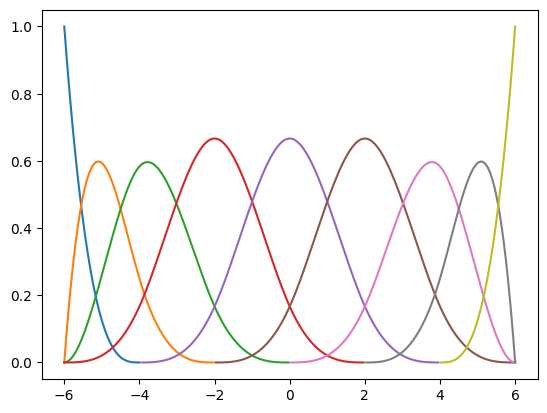

In [11]:
locs = [-6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0]
knots = [locs[0]] * 3 + locs + [locs[-1]] * 3
degree = 3

basis_funcs = [
    BSpline.basis_element(knots[i : i + degree + 2], extrapolate=False)
    for i in range(len(knots) - degree - 1)
]

xs = np.linspace(knots[0], knots[-1] - 1e-6, num=200)
for basis_func in basis_funcs:
    plt.plot(xs, basis_func(xs))

#### Var, skew, curvature

0.46888s --- 0.00047s/it
0.19601s --- 0.00020s/it


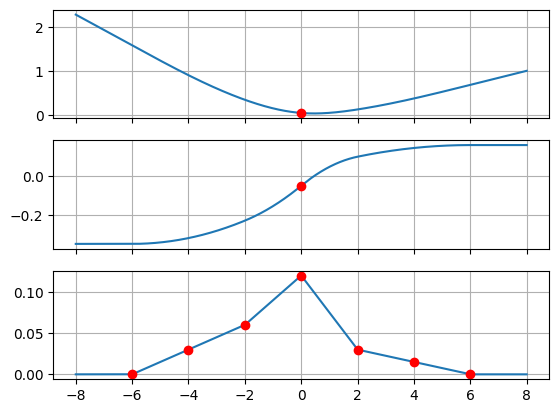

In [12]:
n_trials = 1000

log_mns = np.linspace(-8, 8.0, num=3000)
log_mns_coarse = np.array([-6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0])
strikes = 100 * np.exp(log_mns)
strikes_coarse = 100 * np.exp(log_mns)

start = time.perf_counter()
for i in range(n_trials):
    slc = CviSlice.from_real_params(
        CviRealParams(
            atm_var=0.2 * 0.2,
            skew=5.0,
            nodes=[
                CviNode(-6.0, 0.0),
                CviNode(-4.0, 0.03),
                CviNode(-2.0, 0.06),
                CviNode(0.0, 0.12),
                CviNode(2.0, 0.03),
                CviNode(4.0, 0.015),
                CviNode(6.0, 0.0),
            ],
        ),
        ref_fwd=100.0,
        t_e=1.0,
    )
    
    vols = slc.var_deriv1_deriv2_z(log_mns)
    vols_coarse = slc.var_deriv1_deriv2_z(log_mns_coarse)
end = time.perf_counter()
print(f"{end - start:.5f}s --- {(end - start) / n_trials:.5f}s/it")


# We compare how long it takes the CVI slice to compute vols vs a scipy CubicSpline.
# Our CVI slice is roughly 2.5 times slower.
# If memory serves, calculating cubic spline params (in the regular Natural Cubic Spline case as below)
# is a lower triangular matrix solving problem while in the CVI case, we are solving a tridiagonal 
# matrix problem. We have not yet optimized the calculation so we are actually doing a full matrix inversion.
# Though in this case the matrices are so small that it probably doesn't matter.
# Creating numpy arrays takes ridiculously long so it might just be that poor usage of numpy. TBD.
start = time.perf_counter()
for _ in range(n_trials):
    slc = interpolate.CubicSpline(log_mns, vols[0])
    vols2 = slc(log_mns)
end = time.perf_counter()
print(f"{end - start:.5f}s --- {(end - start) / n_trials:.5f}s/it")

fig, ax = plt.subplots(3, 1, sharex="all")
ax[0].plot(log_mns, vols[0])
ax[0].plot(log_mns_coarse[3], vols_coarse[0][3], "ro")
ax[0].grid()
ax[1].plot(log_mns, vols[1])
ax[1].plot(log_mns_coarse[3], vols_coarse[1][3], "ro")
ax[1].grid()
ax[2].plot(log_mns, vols[2])
ax[2].plot(log_mns_coarse, vols_coarse[2], "ro")
ax[2].grid()
plt.show()

x = 1


## Fitting (UNDER CONSTRUCTION - PARTIALLY WORKING)

In [8]:
import pandas as pd
import numpy as np
from pandera.typing import DataFrame

from cvi.slice import *
from cvi.fitter import CviVolFitter
from cvi.option_chain import OptionChain

chain = DataFrame[OptionChain](pd.read_csv("cvi/examples/data/2023-04-14_vol.csv"))

fitter = CviVolFitter()
node_locs = [-20.0, -15.0, -10.0, -8.0, -6.0, -4.0, -2.0, -1.5, -1.0, -0.5, 0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0, 6.0]
res = fitter.fit(chain, node_locs, verbose=True)

-------------------------------------------------------------
           Clarabel.rs v0.10.0  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 1155
  constraints   = 340
  nnz(P)        = 3922
  nnz(A)        = 804
  cones (total) = 4
    :        Zero = 1,  numel = 110
    : Nonnegative = 3,  numel = (10,110,110)

settings:
  linear algebra: direct / qdldl, precision: 64 bit
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-8, tol_gap_abs = 1.0e-8, tol_gap_rel = 1.0e-8,
  static reg : on, ϵ1 = 1.0e-8, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-7
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12,
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-4, max_scale = 1.0e4
               max iter = 10

iter    pcost        dcos

In [ ]:
from ipywidgets import interact
import plotly.graph_objects as go
from plotly.subplots import make_subplots

expiries = chain["expiry"].unique()
def plot_calibrated_vs_market(expiry: pd.Timestamp = expiries[expiries.shape[0] // 2]):
    slc = res[expiry]

    expiry_chain = chain[chain["expiry"] == expiry]
    expiry_chain = expiry_chain[expiry_chain["z"].abs() < 15.0]
    strikes_chain = expiry_chain["strike"].values
    zs_chain = expiry_chain["z"]
    zs = np.linspace(zs_chain.min() * 0.9, zs_chain.max() * 1.3, num=3000)
    ks = slc.z_to_k(zs)
        
    vols = slc.vol_deriv1_deriv2_z(zs)
    vols_chain = expiry_chain["iv_mid"].values
    errors_chain = (expiry_chain["iv_ask"] - expiry_chain["iv_bid"]).values

    vol = go.Scatter(x=ks, y=vols[0] * 100, name=f"Fitted vols", showlegend=True, mode="lines")
    bidask_vols = go.Scatter(x=strikes_chain, y=vols_chain * 100, name="Mid vols", error_y=go.scatter.ErrorY(array=errors_chain), marker_color="red", showlegend=True, mode="markers")
    deriv1 = go.Scatter(x=ks, y=vols[1] * 100, name=f"Fitted skew (dvol/dz)", showlegend=True, mode="lines")
    deriv2 = go.Scatter(x=ks, y=vols[2] * 100, name=f"Fitted curvature (d2vol/dz2)", showlegend=True, mode="lines")
    
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02, specs=[[{"secondary_y": False}], [{"secondary_y": True}]])
    
    fig.add_trace(vol, row=1, col=1)
    fig.add_trace(bidask_vols, row=1, col=1)
    fig.add_trace(deriv1, row=2, col=1)
    fig.add_trace(deriv2, row=2, col=1, secondary_y=True)
    fig.add_vline(x=slc._ref_fwd, line_dash="dash",line_color="gray")
    fig.update_layout(width=1200, height=700)
    fig.show()
    
interact(plot_calibrated_vs_market, expiry=expiries)

interactive(children=(Dropdown(description='expiry', index=27, options=('2023-04-14 16:00:00', '2023-04-17 16:…

<function __main__.plot_calibrated_vs_market(expiry: pandas._libs.tslibs.timestamps.Timestamp = '2023-05-31 16:00:00')>